# Notícias G1 - 2. Higienização, Stemmer e Stop Words

Aplicaremos técnicas de higienização de dados, stemmer e stop words na massa de dados obtida atravéz da extração do portal do G1 notícias. Essas técnicas serão explicadas ao longo do documento.

## Imports:

Importes de bibliotecas usadas com frequência no código.

In [1]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados pela extração do portal G1.

In [2]:
noticias = pd.read_csv('noticias_g1_baixadas.csv')
print(noticias.shape)
noticias.head()

(3956, 4)


,titulo,url,texto,categoria
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,mundo
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",mundo
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,sp
3,ASSISTA: Gilberto Gil faz live de arraial no G...,https://globoplay.globo.com/arraial-do-gil/ao-...,NaN,arraial-do-gil
4,Athletico-PR bate o Grêmio e assume a liderança,https://ge.globo.com/rs/futebol/brasileirao-se...,NaN,rs


## Removendo Linhas em Branco:

Removendo linhas em branco encontradas na massa de dados.

In [3]:
noticias.dropna(inplace=True)
noticias.reset_index(drop=True, inplace=True)
print(noticias.shape)

(3834, 4)


## Analisando e Tratando Categorias:

### Categorias existentes:

Verificando como as notícias estão originalmente classificadas para encontrar falhas e áreas de interesse.

In [4]:
print(noticias.categoria.unique())

['mundo' 'sp' 'futebol' 'sc' 'rj' 'politica' 'es' 'pe' 'tenis' 'podcast'
 'globo-reporter' 'economia' 'bemestar' 'pop-arte' 'ciencia-e-saude'
 'olha-que-legal' 'df' 'fato-ou-fake' 'mg' 'educacao' 'ms' 'ro' 'pr' 'ce'
 'especiais' 'am' 'rs' 'se' 'rr' 'pi' 'ap' 'monitor-da-violencia'
 'loterias' 'pb' 'pa' 'natureza' 'to' 'go' 'ba' 'al' 'jornal-nacional']


### Removendo categorias que não são relevantes para o problema:

Algumas categorias não são representativas do ponto de vista do negócio, tais como as que são siglas de estados, aquelas cujo nome não identifica a natureza do conteúdo e também as que possuem pouquíssima representatividade (como futebol, por exemplo).

In [5]:
cat_nao_relevantes = ['globonews', 'jornal-nacional', 'mundo', 'fato-ou-fake', 'podcast', 'olha-que-legal', 'globo-reporter', 'especiais', 'monitor-da-violencia', 'loterias', 'mg', 'ms', 'sp', 'rj', 'ce', 'es', 'go', 'mt', 'pr', 'sc', 'pe', 'rn', 'ba', 'ma', 'df', 'pb', 'se', 'ap', 'rs', 'ac', 'am', 'ro', 'rr', 'pi', 'pa', 'to', 'al']
for cat in cat_nao_relevantes:
  noticias.loc[noticias.categoria==cat, 'categoria'] = 'FALTANDO'

categorias = noticias.categoria.unique()
categorias = np.delete(categorias, np.where(categorias == 'FALTANDO'))

print(categorias)

['futebol' 'politica' 'tenis' 'economia' 'bemestar' 'pop-arte'
 'ciencia-e-saude' 'educacao' 'natureza']


### Distribuição por categoria:

Vamos analisar a distribuição das categorias finais com relevância semântica e de interesse para o negócio. 

Podemos observar que as categorias não estão balanceadas e que isso pode gerar um viés na hora de classificas as notícias com categorias desconhecidas. 

Uma forma de tratar esse problema seria fazer um trabalho manual de classificação de algumas notícias para equilibrar o problema do desbalanceamento. Outra solução seria subamostrar as classes com alta representatividade.

In [6]:
distribuicao_noticias = noticias[['categoria', 'texto']].groupby('categoria').count()
distribuicao_noticias_conhecidas = distribuicao_noticias.drop('FALTANDO')
print('Total: ', distribuicao_noticias['texto'].sum())
distribuicao_noticias

Total:  3834


,texto
categoria,
FALTANDO,2111
bemestar,151
ciencia-e-saude,49
economia,648
educacao,48
futebol,2
natureza,7
politica,494
pop-arte,323


### Trabalhando Categorias Com pouca Relevância e Amostragem:

Vamos trabalhar as categorias com poucas amostras como "tenis", "futebol" e "natureza" criando uma categoria diversos. Vamos também unificar "ciencia-e-saude" com "bemestar" na nova categoria "saude".

In [7]:
noticias.loc[noticias.categoria=='bemestar', 'categoria'] = 'saude'
noticias.loc[noticias.categoria=='ciencia-e-saude', 'categoria'] = 'saude'
noticias.loc[noticias.categoria=='tenis', 'categoria'] = 'diversos'
noticias.loc[noticias.categoria=='futebol', 'categoria'] = 'diversos'
noticias.loc[noticias.categoria=='natureza', 'categoria'] = 'diversos'

In [8]:
distribuicao_noticias = noticias[['categoria', 'texto']].groupby('categoria').count()
distribuicao_noticias

,texto
categoria,
FALTANDO,2111
diversos,10
economia,648
educacao,48
politica,494
pop-arte,323
saude,200


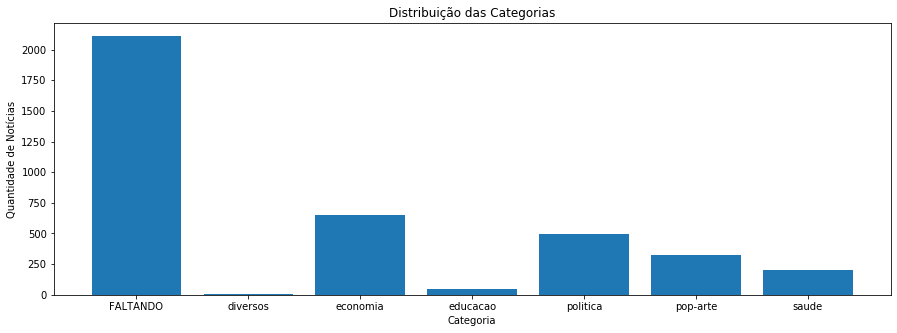

In [15]:
import matplotlib.pyplot as plt 
import numpy

plt.figure(figsize=[15,5])
plt.title('Distribuição das Categorias')
plt.xlabel('Categoria')
plt.ylabel('Quantidade de Notícias')
plt.bar(distribuicao_noticias.index, distribuicao_noticias['texto'])
plt.show()

## Higienização do Texto com Regex:

Realizando higienização para remover elementos irrelevantes para a classificação:
* Caracteres especiais
* Mosóclises (alcançar-te-ei, falar-te-ei)
* Ênclises (falar-me, alcançar-te)
* Hífens perdidos

In [10]:
def higienizar_texto (texto):
  import re
  texto = re.sub('[^a-zA-ZéúíóáÉÚÍÓÁèùìòàÈÙÌÒÀõãñÕÃÑêûîôâÊÛÎÔÂëÿüïöäËYÜÏÖÄçÇ\-\s]', '', texto)
  texto = re.sub('(\-..es)|(\-..e)|(\-.e)|(\-.os)|(\-ei)', '', texto)
  texto = re.sub('\-+', '', texto)
  return texto.lower()

noticias['dado_tratado'] = noticias['titulo'] + ' ' + noticias['texto']
noticias['dado_tratado'] = noticias['dado_tratado'].apply(lambda x: higienizar_texto(x))
noticias.head()

,titulo,url,texto,categoria,dado_tratado
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,FALTANDO,entenda como uma ampla coalizão tirou netanyah...
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",FALTANDO,milionário de direita quem é naftali bennett o...
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,FALTANDO,governo de sp antecipa datas de vacinação veja...
3,PMs que mataram homens dentro de carro em SP s...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,A Polícia Militar instaurou um inquérito poli...,FALTANDO,pms que mataram homens dentro de carro em sp s...
4,"Após Venezuela e Bolívia, Colômbia confirma 2 ...",https://ge.globo.com/futebol/copa-america/noti...,A Federação Colombiana de Futebol informou ne...,diversos,após venezuela e bolívia colômbia confirma ca...


## Stop-Words

Fazendo tratamento de stop words que são palavras sem valor semântico e que não agregam na solução do problema de classificação. Como estamos tratando notícias de diversos assuntos, não teremos palavras extras para acrescentar, o que é comum quando se trata de um assunto específico onde sabe-se previamente quais palavras são mais importantes.

In [11]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

def tratar_stop_words (string):
    return [word for word in string.split() if word not in stopwords]

noticias['dado_tratado'] = noticias['dado_tratado'].apply(lambda x: tratar_stop_words(x))
noticias.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edprata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,titulo,url,texto,categoria,dado_tratado
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,FALTANDO,"[entenda, ampla, coalizão, tirou, netanyahu, p..."
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",FALTANDO,"[milionário, direita, naftali, bennett, novo, ..."
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,FALTANDO,"[governo, sp, antecipa, datas, vacinação, veja..."
3,PMs que mataram homens dentro de carro em SP s...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,A Polícia Militar instaurou um inquérito poli...,FALTANDO,"[pms, mataram, homens, dentro, carro, sp, afas..."
4,"Após Venezuela e Bolívia, Colômbia confirma 2 ...",https://ge.globo.com/futebol/copa-america/noti...,A Federação Colombiana de Futebol informou ne...,diversos,"[após, venezuela, bolívia, colômbia, confirma,..."


## Stemmer:

Aplicando a técnica de Stemmer para reduzir o vocabulário, transformando palavras com o mesmo valor semântico em uma só variável para o problema. Exemplo comuns são o tratamento dos generos como se fosse um só e a redução das palavras ao seu radical, entre outras técnicas.

In [12]:
import nltk
nltk.download('rslp')

from nltk.stem import RSLPStemmer
stemmer_ptbr = RSLPStemmer()

def apply_stem (text):
    return [stemmer_ptbr.stem(word) for word in text]

noticias['dado_tratado'] = noticias['dado_tratado'].apply(lambda x: apply_stem(x))
noticias.head()

[nltk_data] Downloading package rslp to /Users/edprata/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


,titulo,url,texto,categoria,dado_tratado
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,FALTANDO,"[entend, ampl, coaliz, tir, netanyahu, pod, is..."
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",FALTANDO,"[milion, direit, naftal, bennett, nov, premi, ..."
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,FALTANDO,"[govern, sp, antecip, dat, vacin, vej, nov, ca..."
3,PMs que mataram homens dentro de carro em SP s...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,A Polícia Militar instaurou um inquérito poli...,FALTANDO,"[pm, mat, hom, dentr, carr, sp, afast, investi..."
4,"Após Venezuela e Bolívia, Colômbia confirma 2 ...",https://ge.globo.com/futebol/copa-america/noti...,A Federação Colombiana de Futebol informou ne...,diversos,"[após, venezuel, bolív, colômb, confirm, cas, ..."


## Gravando dados Tratados:

Gravando os dados em CSV para posterior utilização.

In [13]:
noticias.to_csv('noticias_g1_higienizadas.csv', index=False)